In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import medmnist
from medmnist import INFO

data_flag = 'pneumoniamnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# 1. Training Transforms (WITH AUGMENTATION)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=10),                      # AUGMENTATION: Rotate up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)), # AUGMENTATION: Shift image slightly
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Validation/Test Transforms (NO AUGMENTATION, just preprocessing)
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Reload datasets
train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset = DataClass(split='val', transform=eval_transform, download=True)
test_dataset = DataClass(split='test', transform=eval_transform, download=True)

# 4. Create DataLoaders
BATCH_SIZE = 32
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders successfully created WITH Data Augmentation for the training set!")

100%|██████████| 4.17M/4.17M [00:01<00:00, 3.46MB/s]


DataLoaders successfully created WITH Data Augmentation for the training set!


In [ ]:
!pip install medmnist

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Downloading Pre-trained Vision Transformer...")
# 1. Load the pre-trained ViT-Base model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# 2. Modify the classification head
# The original model outputs 1000 classes. We change it to output 1 class for our binary BCE loss.
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, 1)

# 3. Move model to GPU
model = model.to(device)

# 4. Define Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()

# Note: We use a much smaller learning rate (1e-4) when fine-tuning a pre-trained transformer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print(f"ViT Model successfully initialized on: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


ViT Model successfully initialized on: cuda


In [ ]:
import time
import torch

num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []  # <-- This line is now fixed!

print("Starting ViT training loop... (This will take longer than the simple CNN)")
start_time = time.time()

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = torch.round(torch.sigmoid(outputs))
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train

    # --- Validation Phase ---
    model.eval()
    val_running_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device, dtype=torch.float32)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_acc = correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds!")

# Save the ViT model weights (Challenge Deliverable)
torch.save(model.state_dict(), 'pneumonia_vit_weights.pth')
print("Model weights successfully saved to 'pneumonia_vit_weights.pth'")

Starting ViT training loop... (This will take longer than the simple CNN)
Epoch [1/10] | Train Loss: 0.0499, Train Acc: 0.9800 | Val Loss: 0.0929, Val Acc: 0.9752
Epoch [2/10] | Train Loss: 0.0606, Train Acc: 0.9775 | Val Loss: 0.1534, Val Acc: 0.9599
Epoch [3/10] | Train Loss: 0.0533, Train Acc: 0.9813 | Val Loss: 0.0625, Val Acc: 0.9809
Epoch [4/10] | Train Loss: 0.0482, Train Acc: 0.9809 | Val Loss: 0.0670, Val Acc: 0.9752
Epoch [5/10] | Train Loss: 0.0446, Train Acc: 0.9824 | Val Loss: 0.1150, Val Acc: 0.9580
Epoch [6/10] | Train Loss: 0.0477, Train Acc: 0.9828 | Val Loss: 0.0845, Val Acc: 0.9752
Epoch [7/10] | Train Loss: 0.0463, Train Acc: 0.9813 | Val Loss: 0.1329, Val Acc: 0.9542
Epoch [8/10] | Train Loss: 0.0435, Train Acc: 0.9826 | Val Loss: 0.1135, Val Acc: 0.9656
Epoch [9/10] | Train Loss: 0.0505, Train Acc: 0.9802 | Val Loss: 0.0637, Val Acc: 0.9790
Epoch [10/10] | Train Loss: 0.0494, Train Acc: 0.9824 | Val Loss: 0.0724, Val Acc: 0.9752
Training completed in 1783.09 secon

Running evaluation on the test set with ViT...

--- Final ViT Test Set Metrics ---
Accuracy:  0.9151
Precision: 0.8946
Recall:    0.9795
F1-Score:  0.9351
ROC-AUC:   0.9816


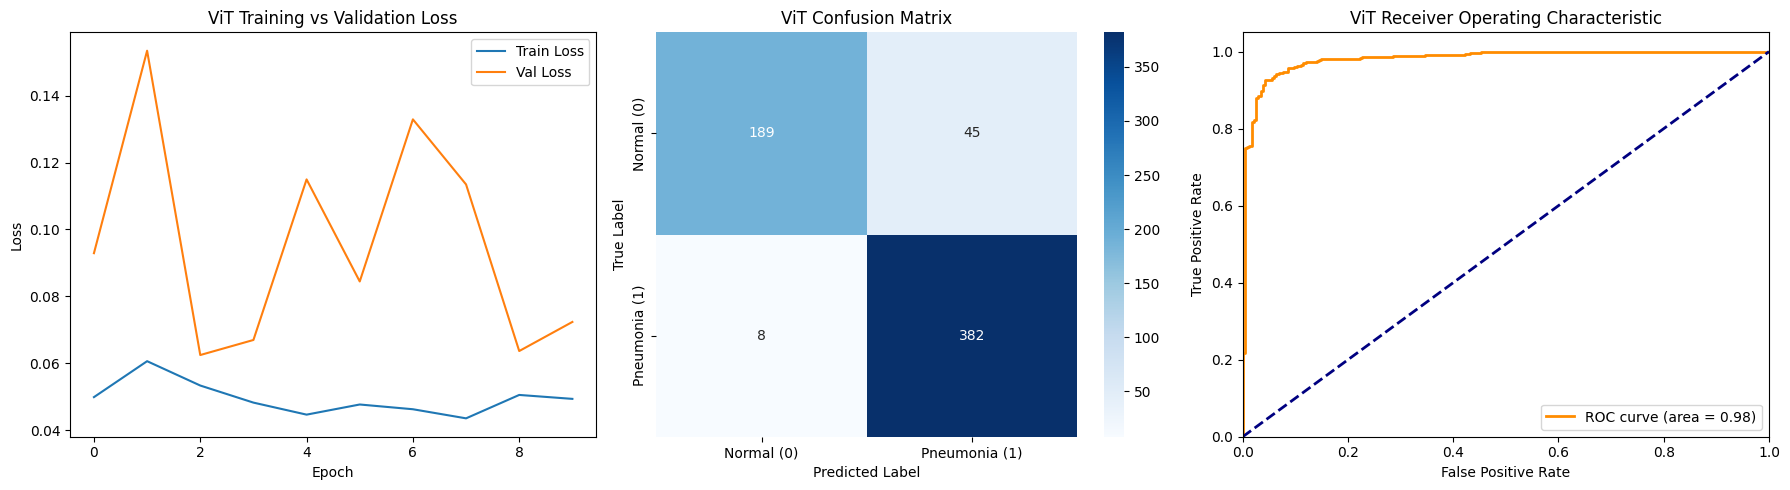

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, roc_curve)

model.eval()
all_targets = []
all_preds_probs = []
all_preds_labels = []

print("Running evaluation on the test set with ViT...")

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device, dtype=torch.float32)

        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = torch.round(probs)

        all_targets.extend(targets.cpu().numpy())
        all_preds_probs.extend(probs.cpu().numpy())
        all_preds_labels.extend(preds.cpu().numpy())

all_targets = np.array(all_targets).flatten()
all_preds_probs = np.array(all_preds_probs).flatten()
all_preds_labels = np.array(all_preds_labels).flatten()

# --- 1. Calculate Standard Metrics ---
acc = accuracy_score(all_targets, all_preds_labels)
prec = precision_score(all_targets, all_preds_labels)
rec = recall_score(all_targets, all_preds_labels)
f1 = f1_score(all_targets, all_preds_labels)
auc = roc_auc_score(all_targets, all_preds_probs)

print("\n--- Final ViT Test Set Metrics ---")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")

# --- 2. Plot Visualizations ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_title("ViT Training vs Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

cm = confusion_matrix(all_targets, all_preds_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal (0)', 'Pneumonia (1)'],
            yticklabels=['Normal (0)', 'Pneumonia (1)'])
axes[1].set_title("ViT Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

fpr, tpr, thresholds = roc_curve(all_targets, all_preds_probs)
axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ViT Receiver Operating Characteristic')
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

Extracting failure cases...


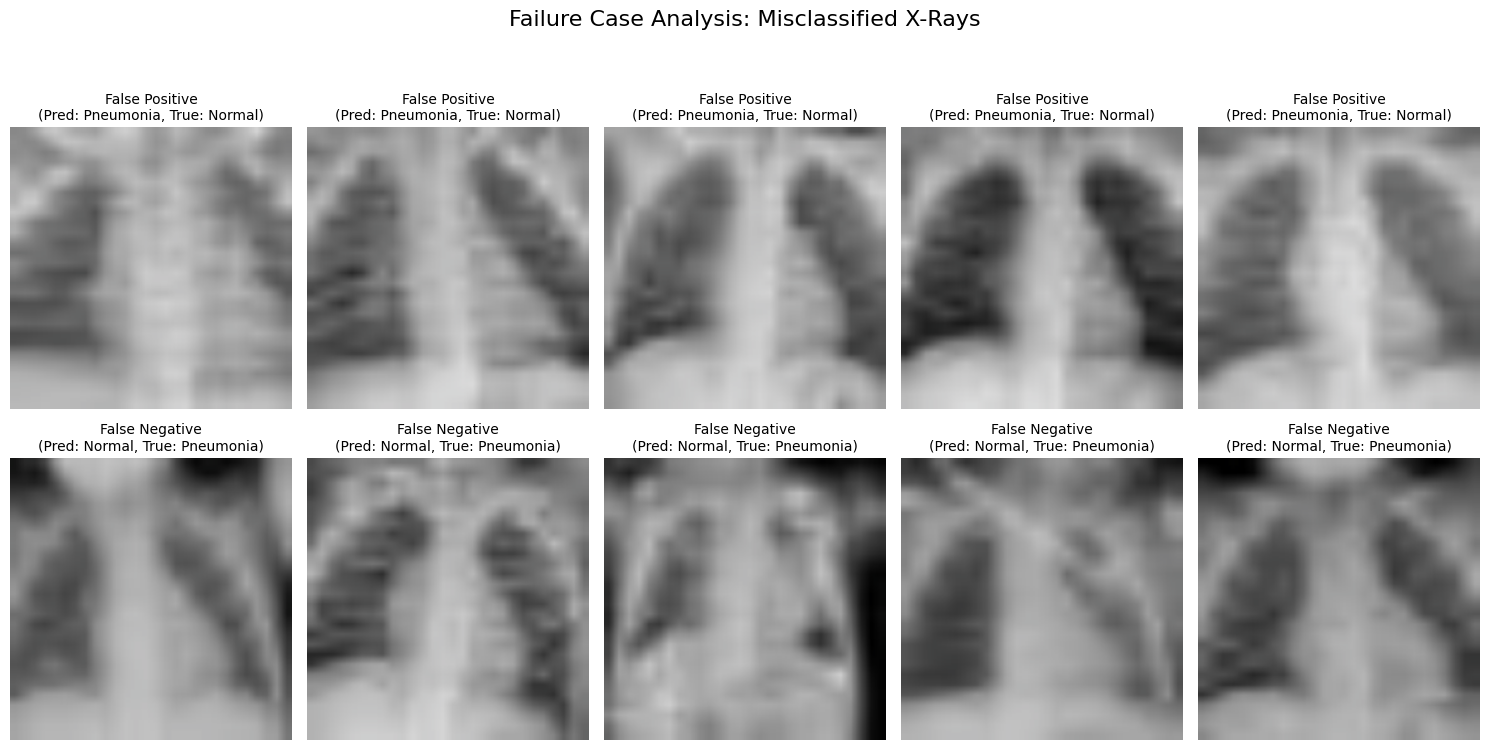


Total False Positives: 45
Total False Negatives: 8


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is in eval mode and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

false_positives = [] # Predicted 1, Actual 0
false_negatives = [] # Predicted 0, Actual 1

print("Extracting failure cases...")

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device, dtype=torch.float32)
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)
        preds = torch.round(probs)

        # Move to CPU for processing
        inputs_cpu = inputs.cpu()
        preds_cpu = preds.cpu().numpy().flatten()
        targets_cpu = targets.cpu().numpy().flatten()

        for i in range(len(preds_cpu)):
            pred = preds_cpu[i]
            true = targets_cpu[i]
            img = inputs_cpu[i]

            if pred == 1 and true == 0:
                false_positives.append(img)
            elif pred == 0 and true == 1:
                false_negatives.append(img)

# --- Helper function with Channel-Last fix ---
def imshow_unnormalized(img_tensor, ax, title):
    """
    Handles the (C, H, W) -> (H, W, C) conversion and un-normalization
    """
    # ImageNet stats used in your transforms
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # 1. Convert to numpy
    npimg = img_tensor.numpy()

    # 2. Un-normalize: (img * std) + mean
    # We use [:, None, None] to broadcast across the Height and Width
    npimg = npimg * std[:, None, None] + mean[:, None, None]

    # 3. FIX: Transpose from (3, 224, 224) to (224, 224, 3)
    npimg = np.transpose(npimg, (1, 2, 0))

    # 4. Clip to valid [0, 1] range for imshow
    npimg = np.clip(npimg, 0, 1)

    ax.imshow(npimg)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# --- Plotting the Failure Cases ---
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle("Failure Case Analysis: Misclassified X-Rays", fontsize=16)

# Plot up to 5 False Positives (Top Row)
for i in range(5):
    ax = axes[0, i]
    if i < len(false_positives):
        imshow_unnormalized(false_positives[i], ax, "False Positive\n(Pred: Pneumonia, True: Normal)")
    else:
        ax.axis('off') # Hide empty subplot if fewer than 5 errors

# Plot up to 5 False Negatives (Bottom Row)
for i in range(5):
    ax = axes[1, i]
    if i < len(false_negatives):
        imshow_unnormalized(false_negatives[i], ax, "False Negative\n(Pred: Normal, True: Pneumonia)")
    else:
        ax.axis('off') # Hide empty subplot

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

print(f"\nTotal False Positives: {len(false_positives)}")
print(f"Total False Negatives: {len(false_negatives)}")